## Looking Into Missing Data Imputation

- there should be 6 hours of missing data at the end
- "bus_data_before_missing.csv" is about 4 days up to the missing chunk
- "bus_data_after_missing.csv" is 24 hours after the missing chunk



In [5]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Locating the Missing Data

Data is missing from 4:05 - 9:46 on the 02-24-2026


In [29]:
# choose data
#path = 'bus_data_before_missing.csv'
path = 'bus_data_after_missing.csv'

In [30]:
# import data
week = pd.read_csv(path)

# add column for numeric day
week['day'] = pd.to_datetime(week['tmstmp']).dt.day

# week.head()

/var/folders/hh/2dsrbb3d021_w0zs6jdygn480000gn/T/ipykernel_72049/486393818.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  week = pd.read_csv(path)


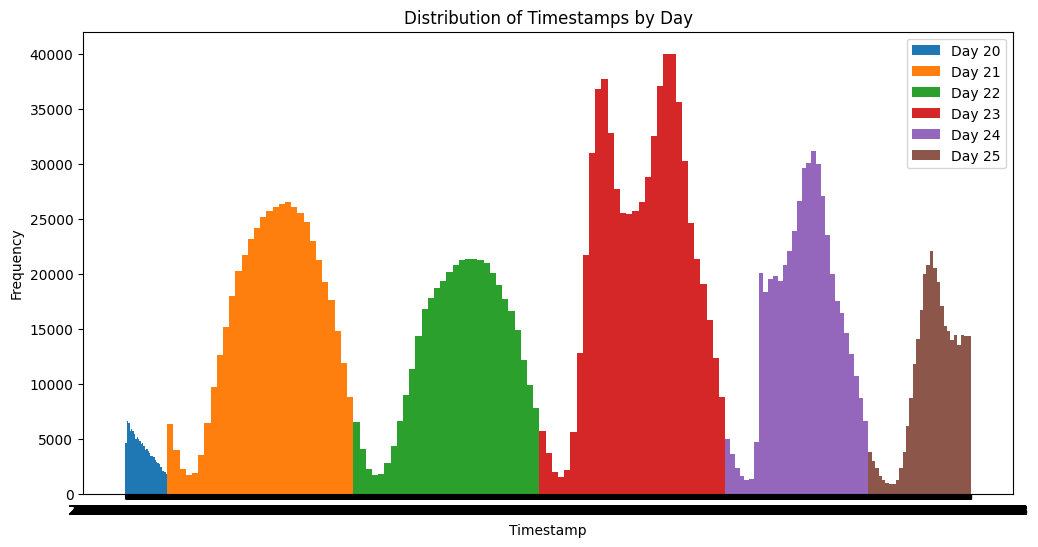

In [31]:
# plot tmstmp (timestamps) to see where the missing data exists
# histogram
# use different color for each day in week['day]

plt.figure(figsize=(12, 6))
for day in week['day'].unique():
    day_data = week[week['day'] == day]
    plt.hist(day_data['tmstmp'],label=f'Day {day}', bins = 30)
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps by Day')
plt.legend()
plt.show()

missing data occuring in the last day... on the 24th?

In [32]:
# filter out 20206 02 24 values (starts with 20260224)

day24 = week[week['day'] == 24]

day24.head()


,vid,tmstmp,lat,lon,hdg,pid,rt,des,pdist,dly,...,origtatripno,tablockid,zone,mode,psgld,stst,stsd,pulled_at,rt_chunk,day
1687869,8405,20260224 00:00,41.891856,-87.624094,357,18414,3,Michigan/Chicago,66459,False,...,273997116,3 -773,NaN,1,NaN,83040,2026-02-23,2026-02-24 00:00:12 CST,"1,2,3,4,X4,N5,6,7,8,8A",24
1687870,8140,20260224 00:00,41.893429,-87.619881,255,18415,3,95th Red Line,0,False,...,273997234,3 -717,NaN,1,NaN,86880,2026-02-23,2026-02-24 00:00:12 CST,"1,2,3,4,X4,N5,6,7,8,8A",24
1687872,1202,20260224 00:00,41.857528,-87.623935,169,18415,3,95th Red Line,16779,False,...,273997232,3 -770,NaN,1,NaN,84840,2026-02-23,2026-02-24 00:00:12 CST,"1,2,3,4,X4,N5,6,7,8,8A",24
1687873,1347,20260224 00:00,41.794805,-87.616020,178,18415,3,95th Red Line,41008,False,...,273997231,3 -709,NaN,1,NaN,84090,2026-02-23,2026-02-24 00:00:12 CST,"1,2,3,4,X4,N5,6,7,8,8A",24
1687874,7964,20260224 00:00,41.772567,-87.615533,178,18415,3,95th Red Line,49139,False,...,273997230,3 -775,NaN,1,NaN,83340,2026-02-23,2026-02-24 00:00:12 CST,"1,2,3,4,X4,N5,6,7,8,8A",24


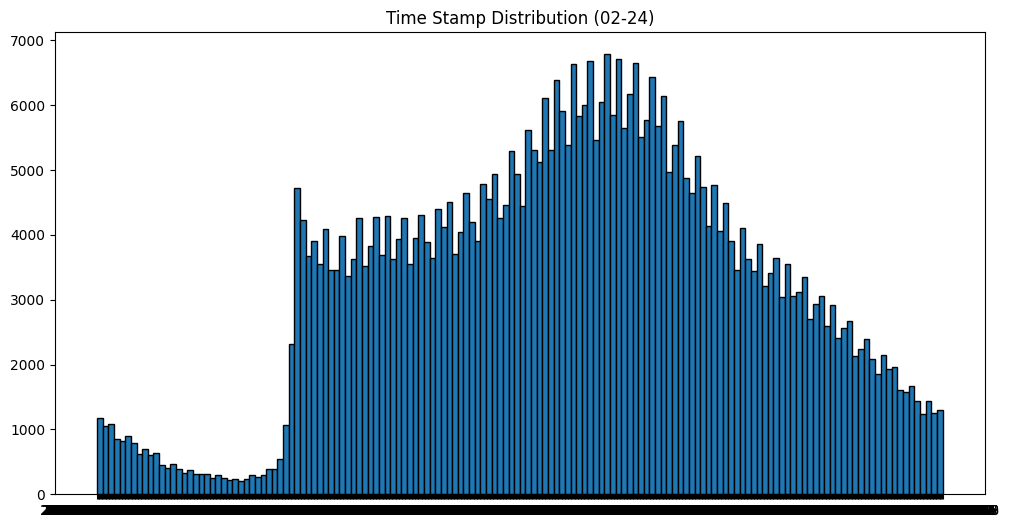

In [33]:
# plot tmstmp (timestamps) to see where the missing data exists
plt.figure(figsize=(12, 6))
plt.hist(day24['tmstmp'], bins=150, edgecolor='black')
plt.title('Time Stamp Distribution (02-24)')
plt.show()

In [35]:
#day24['tmstmp'].unique().tolist()

### Testing Imputation Methods

- take all data from 10am-1pm
- remove data from 11-12pm from 2-24
- test methods of imputation

In [48]:
# create dataset with only data from 10am-1pm for all days

subset = week[(pd.to_datetime(week['tmstmp']).dt.hour >= 10) & (pd.to_datetime(week['tmstmp']).dt.hour < 13)]
#subset.head()

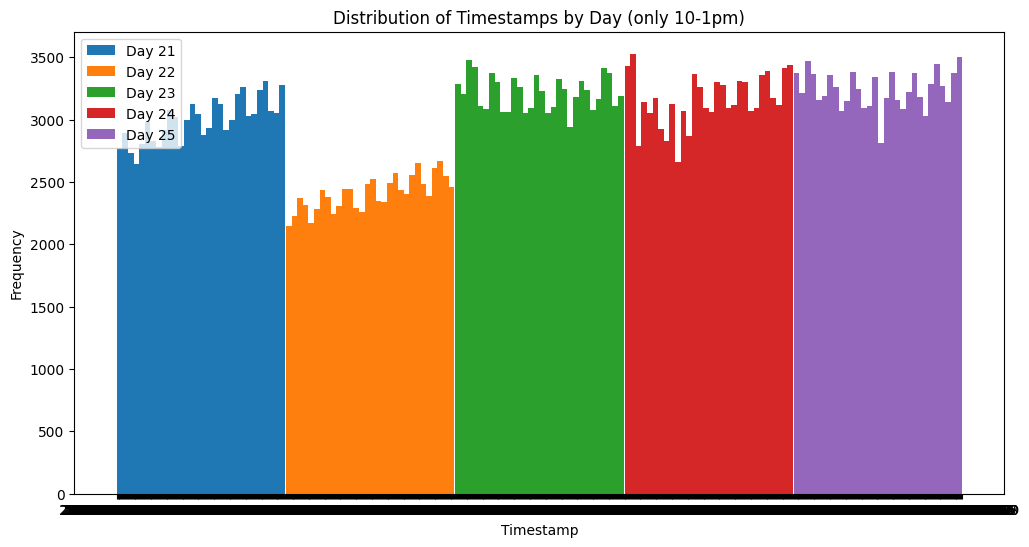

In [50]:
# plot
plt.figure(figsize=(12, 6))
for day in subset['day'].unique():
    day_data = subset[subset['day'] == day]
    plt.hist(day_data['tmstmp'],label=f'Day {day}', bins = 30)
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps by Day (only 10-1pm)')
plt.legend()
plt.show()

In [54]:
# create dataset that is missing 11-12pm data for 2-24
subset_missing = subset[~((subset['day'] == 24) & (pd.to_datetime(subset['tmstmp']).dt.hour == 11))]

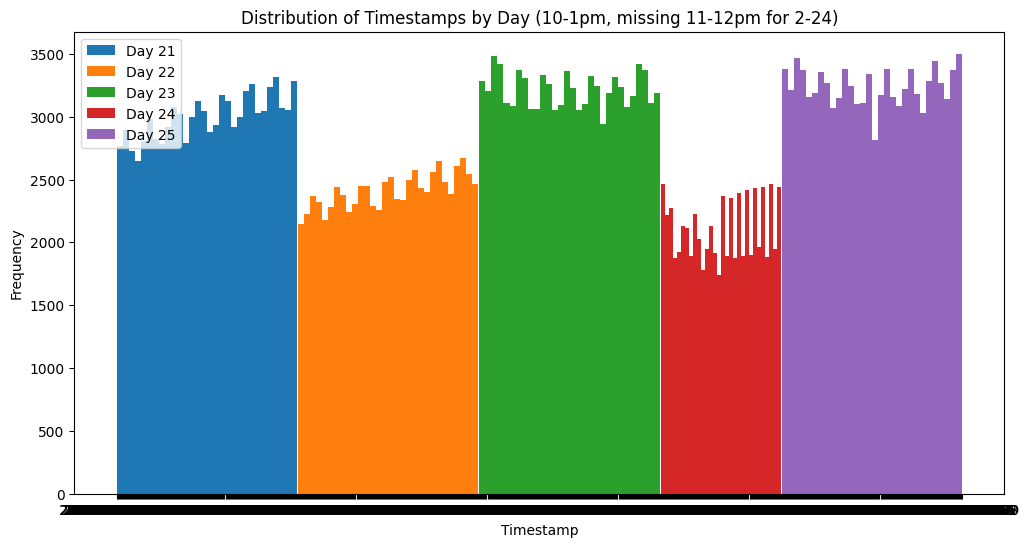

In [55]:
# plot
plt.figure(figsize=(12, 6))
for day in subset_missing['day'].unique():
    day_data = subset_missing[subset_missing['day'] == day]
    plt.hist(day_data['tmstmp'],label=f'Day {day}', bins = 30)
plt.xlabel('Timestamp')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps by Day (10-1pm, missing 11-12pm for 2-24)')
plt.legend()
plt.show()

Problem: cta bus dataset has ~5 hours of missing data from the middle of the draw. 

Created a subset of data using only hours of 10-1pm, and removed 11-12pm from a single data. We have this data to verify accuracy of imputation methods. 

We can use data from before and after the missing period to help reconstruct. 

Here, we are not only filling in missing data in existing rows, but we have to create entirely new rows. 

# time series reconstruction problem

1. for each vehicle id, we have trajectory from before and after the gap
    - for vids that exist on both sides, we can interpolate based on existing data
    - for vids that exist on a single side, ignore these for now
2. 


# or: create a database with time from point a to point b on each route?

In [59]:
# identify vehicle ids that exist both before and after missing data

beforeGap = subset_missing[(subset_missing['day'] == 24) & (pd.to_datetime(subset_missing['tmstmp']).dt.hour < 11)]
afterGap = subset_missing[(subset_missing['day'] == 24) & (pd.to_datetime(subset_missing['tmstmp']).dt.hour >= 12)]

before_ids = set(beforeGap['vid'].unique())
after_ids = set(afterGap['vid'].unique())
common_ids = before_ids.intersection(after_ids) # vehicle ids that exist before and after the gap

In [63]:
# create a database for each common id with common id, time stamp before gap, latitude and longitude before gap, time stamp after gap, latitude and longitude after gap, and the time difference between the two timestamps

common_id_df = pd.DataFrame(columns=['vid', 'tmstmp_before', 'lat_before', 'lon_before', 'tmstmp_after', 'lat_after', 'lon_after', 'time_diff_minutes'])
common_id_df['vid'] = list(common_ids)

for vid in common_ids: # for each common vehicle id, find the corresponding data before and after the gap. check over this
    before_data = beforeGap[beforeGap['vid'] == vid]
    after_data = afterGap[afterGap['vid'] == vid]
    
    if not before_data.empty and not after_data.empty:
        tmstmp_before = before_data['tmstmp'].iloc[0]
        lat_before = before_data['lat'].iloc[0]
        lon_before = before_data['lon'].iloc[0]
        
        tmstmp_after = after_data['tmstmp'].iloc[0]
        lat_after = after_data['lat'].iloc[0]
        lon_after = after_data['lon'].iloc[0]
        
        time_diff_minutes = (pd.to_datetime(tmstmp_after) - pd.to_datetime(tmstmp_before)).total_seconds() / 60
        
        common_id_df.loc[common_id_df['vid'] == vid, ['tmstmp_before', 'lat_before', 'lon_before', 'tmstmp_after', 'lat_after', 'lon_after', 'time_diff_minutes']] = [tmstmp_before, lat_before, lon_before, tmstmp_after, lat_after, lon_after, time_diff_minutes]


In [68]:
common_id_df.tail(10)

,vid,tmstmp_before,lat_before,lon_before,tmstmp_after,lat_after,lon_after,time_diff_minutes
853,8180,20260224 10:01,41.830818,-87.640774,20260224 12:00,41.830791,-87.643604,119.0
854,8181,20260224 10:01,41.893173,-87.745655,20260224 12:00,41.900977,-87.74588,119.0
855,8179,20260224 10:00,41.909439,-87.765311,20260224 12:00,41.910078,-87.715006,120.0
856,8183,20260224 10:00,41.900349,-87.631348,20260224 12:00,41.90374,-87.640377,120.0
857,8182,20260224 10:01,41.911369,-87.630825,20260224 12:00,41.910666,-87.665815,119.0
858,8185,20260224 10:00,41.778858,-87.710098,20260224 12:00,41.77941,-87.666722,120.0
859,4090,20260224 10:00,41.91287,-87.63302,20260224 12:00,41.940052,-87.644836,120.0
860,4091,20260224 10:01,41.881989,-87.629272,20260224 12:01,41.793079,-87.580101,120.0
861,4084,20260224 10:00,41.905864,-87.633087,20260224 12:00,41.877693,-87.640098,120.0
862,8191,20260224 10:00,41.846199,-87.717206,20260224 12:00,41.897288,-87.711499,120.0


'20260224 10:57'